In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from torch import Tensor
import torch
import torch.nn as nn
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

In [71]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')

In [72]:
df.head()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1


In [73]:
# 기존 Feature로 의미있는 Feature 생성
df['acc_ratio'] = df['acc_now_delinq'] / df['open_acc']

In [74]:
df.nunique().tail()

total_rec_int      85095
fico_range_low        38
fico_range_high       38
depvar                 2
acc_ratio             42
dtype: int64

In [75]:
df = df.drop(columns=['delinq_amnt', 'out_prncp', 'out_prncp_inv', 'acc_now_delinq', 'funded_amnt_inv'])

In [77]:
df[df['acc_ratio'] > 0.0001].shape

(541, 72)

## 전체 Feature 전처리 시작

In [80]:
# df_proc은 단순 컬럼 생성 및 삭제 까지 진행
df_proc = df.copy()

In [83]:
# data의 상한값 정해주기
df_proc.loc[df_proc['tot_cur_bal']>1200000, 'tot_cur_bal'] = 1200000
df_proc.loc[df_proc['annual_inc']>480000, 'annual_inc'] = 480000
df_proc.loc[df_proc['revol_bal']>290000, 'revol_bal'] = 290000
df_proc.loc[df_proc['revol_util']>1.785, 'revol_util'] = 1.785
df_proc.loc[df_proc['total_rec_late_fee']>53, 'total_rec_late_fee'] = 53
df_proc.loc[df_proc['total_acc']>89, 'total_acc'] = 89
df_proc.loc[df_proc['open_acc']>41, 'open_acc'] = 41
df_proc.loc[df_proc['tot_coll_amt']>0.00008, 'tot_coll_amt'] = 0.00008

In [84]:
# 구간으로 축약하기 (13개) // aux(auxiliary) = 보조의
auxtotal_rec_int = pd.cut(df_proc['total_rec_int'], 6) 
auxint_rate = pd.cut(df_proc['int_rate'], 15)      # 뒤쪽일수록 1비율 큼. 의미O
auxinstallment = pd.cut(df_proc['installment'], 15)  #특징 X
auxtot_cur_bal = pd.cut(df_proc['tot_cur_bal'], 10)  #뒤쪽으로 갈수록 1비율 낮음
auxdti = pd.cut(df_proc['dti'], 10)                # 뒤쪽으로 갈수록 0비율 높음 의미O
auxannual_inc = pd.cut(df_proc['annual_inc'], 10)  # 처음 1구간에 몰려있음
auxrevol_bal = pd.cut(df_proc['revol_bal'], 10)    # 처음 2구간에 몰려있음
auxrevol_util = pd.cut(df_proc['revol_util'], 10)  # 처음 2구간에 몰려있음
auxtotal_acc = pd.cut(df_proc['total_acc'], 10)    #특징 X
auxopen_acc = pd.cut(df_proc['open_acc'], 10)      #특징 X
auxfico_range_low = pd.cut(df_proc['fico_range_low'], 10)  #앞쪽일수록 1비율 큼. 의미O
auxfico_range_high = pd.cut(df_proc['fico_range_high'], 10)  #앞쪽일수록 1비율 큼. 의미O
auxfunded_amnt = pd.cut(df_proc['funded_amnt'], 10)  #앞쪽일 수록 0이 살짝 큰것같은데 미미함.

# aux_list 13개
aux_dict = {'total_rec_int':auxtotal_rec_int, 'int_rate':auxint_rate, 'installment':auxinstallment, 
            'tot_cur_bal':auxtot_cur_bal, 'dti':auxdti, 'annual_inc':auxannual_inc, 'revol_bal':auxrevol_bal, 'revol_util':auxrevol_util,
            'total_acc':auxtotal_acc, 'open_acc': auxopen_acc, 'fico_range_low':auxfico_range_low,
            'fico_range_high':auxfico_range_high, 'funded_amnt':auxfunded_amnt}

In [85]:
# df_proc_2 부터는 구간 라벨링 시작
df_proc_2 = df_proc.copy()

In [86]:
# Label넣어줄 리스트 생성
col_for_label = ['total_rec_int', 'int_rate',  'installment', 'tot_cur_bal',
                 'dti', 'annual_inc', 'revol_bal', 'revol_util', 'total_acc', 'open_acc', 'fico_range_low', 'fico_range_high', 'funded_amnt']

# name이 string타입이라 그냥 넣어주면 됨
for name in col_for_label:
    df_proc_2[name] = LabelEncoder().fit_transform(aux_dict[name])

In [87]:
df_proc_2.head()  # 현재 acc_ratio가 마지막에 있음

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,total_rec_int,fico_range_low,fico_range_high,depvar,acc_ratio
0,1,0,5,0,1,0,0,2,0,0.00000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1,4,0,0,0,5,5,0,0.0
1,4,1,0,0,1,1,0,2,0,0.00000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0.0,1,1,2,2,0,0,0,0,0.0
2,4,0,4,0,3,0,0,1,0,0.00000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,1,1,1,4,0,0,0,0,0.0
3,4,1,3,4,2,0,0,3,0,0.00000,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,3,0.0,1,2,4,2,0,1,1,1,0.0
4,4,0,5,0,1,2,0,1,0,0.00008,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,2,0.0,1,1,2,2,0,0,0,1,0.0


In [88]:
#수동으로 구간 작업한 것 넣어주기

# 코드 순서주의!!!!
df_proc_2.loc[(df_proc_2['total_rec_late_fee'] > 1.7) & (df_proc_2['total_rec_late_fee'] <= 12), 'total_rec_late_fee'] = 4
df_proc_2.loc[df_proc_2['total_rec_late_fee']  > 12, 'total_rec_late_fee'] = 5
df_proc_2.loc[(df_proc_2['total_rec_late_fee'] > 0.06) & (df_proc_2['total_rec_late_fee'] <= 1.7), 'total_rec_late_fee'] = 3
df_proc_2.loc[(df_proc_2['total_rec_late_fee'] > 0.002) & (df_proc_2['total_rec_late_fee'] <= 0.06), 'total_rec_late_fee'] = 2
df_proc_2.loc[(df_proc_2['total_rec_late_fee'] > 0.000001) & (df_proc_2['total_rec_late_fee'] <= 0.002), 'total_rec_late_fee'] = 1
df_proc_2.loc[ df_proc_2['total_rec_late_fee'] <= 0.000001, 'total_rec_late_fee'] = 0

df_proc_2.loc[df_proc_2['tot_coll_amt']  > 0.02, 'tot_coll_amt'] = 2
df_proc_2.loc[(df_proc_2['tot_coll_amt'] > 0.00001) & (df_proc_2['tot_coll_amt'] <= 0.02), 'tot_coll_amt'] = 1
df_proc_2.loc[df_proc_2['tot_coll_amt'] <= 0.00001, 'tot_coll_amt'] = 0

df_proc_2.loc[df_proc_2['delinq_2yrs'] <= 4, 'delinq_2yrs'] = 0                                     #4년이하 2:1 비율
df_proc_2.loc[(df_proc_2['delinq_2yrs'] > 4) & (df_proc_2['delinq_2yrs'] <= 10), 'delinq_2yrs'] = 1 #5~8년 채무불이행비율 증가
df_proc_2.loc[df_proc_2['delinq_2yrs']  > 10, 'delinq_2yrs'] = 2                                    #9년 이상

df_proc_2.loc[df_proc_2['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0     # 0번 추심 발생횟수
df_proc_2.loc[df_proc_2['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1     # 1번 이상

df_proc_2.loc[df_proc_2['tax_liens'] <= 0.1, 'tax_liens'] = 0                                   #0번 세금 저당권 2:1 비율
df_proc_2.loc[(df_proc_2['tax_liens'] > 0.1) & (df_proc_2['tax_liens'] <= 1.5), 'tax_liens'] = 1 #1번 채무불이행비율 증가
df_proc_2.loc[df_proc_2['tax_liens']  > 1.5, 'tax_liens'] = 2 

df_proc_2.loc[df_proc_2['pub_rec'] <= 0.1, 'pub_rec'] = 0                                   #파산 횟수 0번
df_proc_2.loc[(df_proc_2['pub_rec'] > 0.1) & (df_proc_2['pub_rec'] <= 4.2), 'pub_rec'] = 1  #1~4번
df_proc_2.loc[df_proc_2['pub_rec']  > 4.2, 'pub_rec'] = 2                                   #5회 이상

# 코드 넣는 순서 중요!! 거꾸로 하면 0.35 이상은 다 5로 바꿔버림
df_proc_2.loc[df['acc_ratio']  > 0.35, 'acc_ratio'] = 5
df_proc_2.loc[(df['acc_ratio'] > 0.15) & (df_proc_2['acc_ratio'] <= 0.35), 'acc_ratio'] = 4
df_proc_2.loc[(df['acc_ratio'] > 0.05) & (df_proc_2['acc_ratio'] <= 0.15), 'acc_ratio'] = 3
df_proc_2.loc[(df['acc_ratio'] > 0.035) & (df_proc_2['acc_ratio'] <= 0.05), 'acc_ratio'] = 2
df_proc_2.loc[(df['acc_ratio'] > 0.0001) & (df_proc_2['acc_ratio'] <= 0.035), 'acc_ratio'] = 1
df_proc_2.loc[df['acc_ratio'] <= 0.0001, 'acc_ratio'] = 0 

In [89]:
df_proc_2.acc_ratio.unique()

array([0., 3., 2., 4., 1., 5.])

In [ ]:
df_proc_2.info()

In [97]:
df_proc_2.describe()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,total_rec_int,fico_range_low,fico_range_high,depvar,acc_ratio
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,4.060870,0.913440,3.202440,0.008470,0.668880,0.18241,0.176950,2.099330,0.017100,0.158430,0.700620,0.009630,0.051010,0.065400,0.326240,0.089410,0.08058,0.059480,0.060710,0.046640,0.045320,0.045690,0.038570,0.075550,0.066410,0.000330,0.466120,0.000070,0.000050,0.110880,0.422550,0.321800,0.390200,0.288000,0.009620,0.226720,0.582810,0.0,0.060400,0.004250,0.019830,0.01101,0.007310,0.058200,0.000650,0.011250,0.007070,0.000880,0.434430,0.565570,0.489320,0.052360,0.060090,0.045700,0.050750,0.048560,0.051340,0.053430,0.048960,0.050030,0.049460,2.751670,0.327560,0.855920,2.029040,3.45266,2.519220,0.180810,1.325530,1.322630,0.325690,0.016220
std,2.608132,1.050894,1.695638,0.097048,0.952044,0.39235,0.627234,1.389648,0.129645,0.365146,1.157482,0.110079,0.269942,0.247232,0.468839,0.285336,0.27219,0.236522,0.238799,0.210868,0.208006,0.208813,0.192569,0.264278,0.248999,0.018163,0.498853,0.008366,0.007071,0.313985,0.493968,0.467169,0.487797,0.452833,0.097609,0.418712,0.493097,0.0,0.238228,0.065054,0.139417,0.10435,0.085186,0.234122,0.025487,0.105468,0.083786,0.029652,0.495684,0.495684,0.499888,0.222753,0.237655,0.208835,0.219488,0.214947,0.220691,0.224891,0.215786,0.218008,0.216828,2.119761,1.236738,0.351173,1.382749,2.57069,1.358002,0.516876,1.551427,1.541721,0.468634,0.223333
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,

In [91]:
print(list(df_proc_2.nunique()))

[15, 10, 10, 3, 7, 3, 10, 10, 2, 2, 10, 7, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 10, 5, 2, 10, 15, 10, 6, 10, 10, 2, 6]


In [92]:
len(df_proc_2.columns)

72

In [93]:
df_proc_2.nunique().head(10)

int_rate                      15
annual_inc                    10
dti                           10
delinq_2yrs                    3
inq_last_6mths                 7
pub_rec                        3
revol_bal                     10
total_acc                     10
collections_12_mths_ex_med     2
tot_coll_amt                   2
dtype: int64

In [ ]:
col_for_dummies = list(df_proc_2.columns)
col_for_dummies.remove('depvar')
col_for_dummies

In [110]:
# df_proc_3 = 원핫인코딩으로 바꿔줌
df_proc_3 = pd.get_dummies(df_proc_2, columns=col_for_dummies)
df_proc_3.columns

Index(['depvar', 'int_rate_0', 'int_rate_1', 'int_rate_2', 'int_rate_3',
       'int_rate_4', 'int_rate_5', 'int_rate_6', 'int_rate_7', 'int_rate_8',
       ...
       'fico_range_high_6', 'fico_range_high_7', 'fico_range_high_8',
       'fico_range_high_9', 'acc_ratio_0.0', 'acc_ratio_1.0', 'acc_ratio_2.0',
       'acc_ratio_3.0', 'acc_ratio_4.0', 'acc_ratio_5.0'],
      dtype='object', length=272)

In [112]:
# Train, Valid split
X = df_proc_3.drop('depvar', axis=1)
y = df_proc_3['depvar']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X_train_names = X_train.columns

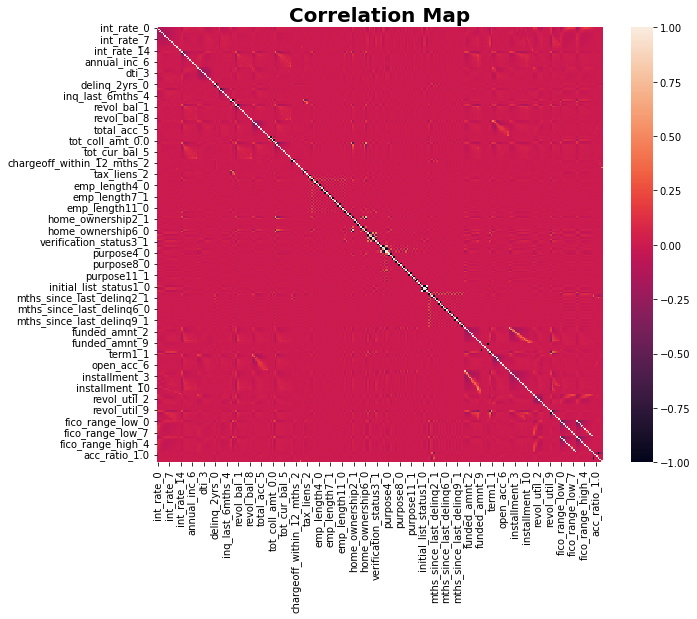

In [104]:
corr_train = X_train.corr()
fig, axs = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_train).set_title("Correlation Map",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
plt.show()

In [113]:
X_train = StandardScaler().fit_transform(X_train)
X_valid = StandardScaler().fit_transform(X_valid)

In [114]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_predDT = decision_tree.predict(X_valid)

print("Accuracy of the model: ",round(decision_tree.score(X_train, y_train) * 100, 2))

Accuracy of the model:  100.0


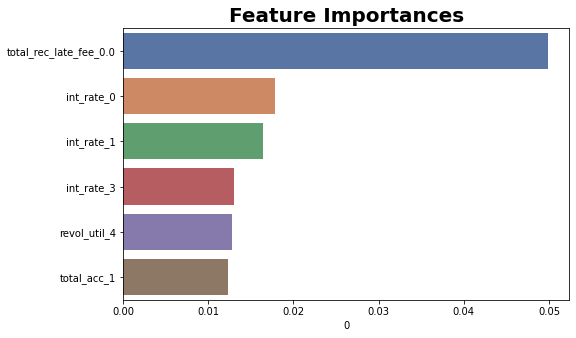

In [115]:
importances = pd.DataFrame(decision_tree.feature_importances_, index = X_train_names)
importances.sort_values(by = 0, inplace=True, ascending = False)
importances = importances.iloc[0:6,:] 

plt.figure(figsize=(8, 5)) 
sns.barplot(x=0, y=importances.index, data=importances,palette="deep").set_title("Feature Importances",
                                                                                 fontdict= { 'fontsize': 20,
                                                                                            'fontweight':'bold'})
plt.show()